## データの読込

In [1]:
import pandas as pd
df = pd.read_csv("vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,...,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,...,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,...,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,...,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


In [2]:
import os
import time
import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from natsort import natsorted 

import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import torch
from pytorch_tabnet.tab_model import TabNetRegressor

import warnings
warnings.simplefilter('ignore')

In [3]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1), 
                                                    df.dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=SEED
                                                    ) 

In [5]:
### パイプライン

# 数値データカラム名を取得
number_columns = list(X_train.select_dtypes(include="number").columns)

# カテゴリデータカラム名を取得
category_columns = X_train.select_dtypes(include="object").columns.tolist()

# カテゴリデータカラムの各カラムのカテゴリーの数を取得
category_unique_num = X_train.select_dtypes(include="object").nunique()

# 数値データ用の変換
numeric_transformer = Pipeline(steps=[
    ('num_imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())]
)

# カテゴリーの数にしきい値を設けて、カテゴリー数の多いカラムと少ないカラムに分ける
thread = 10
many_kinds_category_columns = category_unique_num[category_unique_num >= thread].index.tolist()
few_kinds_category_columns = category_unique_num[category_unique_num < thread].index.tolist()

# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping = []

for column in many_kinds_category_columns:
    ordinal_one_cols_mapping = []
    for category in natsorted(X_train[column].unique()):
        ordinal_one_cols_mapping.append(category)

    ordinal_all_cols_mapping.append(ordinal_one_cols_mapping)

# カテゴリー数が多いカテゴリーデータ用の変換
many_kinds_categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('ordinal', OrdinalEncoder(
                handle_unknown = 'use_encoded_value', # 未知数をunknown valueに置き換える設定
                unknown_value = -1,
                categories = ordinal_all_cols_mapping
            )
        )
])

# カテゴリー数が少ないカテゴリーデータ用の変換
few_kinds_categorical_transformer = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

# ColumnTransformerの作成
columns_transformers = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, number_columns),
        ('many_kinds', many_kinds_categorical_transformer, many_kinds_category_columns),
        ('few_kinds', few_kinds_categorical_transformer, few_kinds_category_columns)
    ]
)

# カラム変換用のパイプラインの作成
transformer = Pipeline(
    [
        ("columns_transformers", columns_transformers),
    ]
)

### LighgGBM

In [6]:
# パイプラインの作成
pipe = Pipeline(
    [
        ("columns_transformers", columns_transformers),
        ('model', lgb.LGBMRegressor(random_state=42))
     ]
)

In [7]:
# 学習・推論
gkf = GroupKFold(n_splits=5)

groups = X_train["Genre"]

cv_result_lgbm = []

for i, (train_index, test_index) in enumerate(gkf.split(X_train, y_train, groups)):
    X_train_gkf, X_test_gkf = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_gkf, y_test_gkf = y_train.iloc[train_index], y_train.iloc[test_index]

    # 学習、推論
    history = pipe.fit(X_train_gkf, y_train_gkf)

    y_pred = pipe.predict(X_test_gkf)

    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result_lgbm.append(rmse)

print("RMSE:", cv_result_lgbm)
print("RMSE:", np.mean(cv_result_lgbm))

RMSE: [0.3381069648542431, 0.10717670046871884, 0.15152424264212594, 0.02716385550389459, 0.3365058004617997]
RMSE: 0.1920955127861564


### TabNet

In [8]:
# カラムの変換
X_train_tf = transformer.fit_transform(X_train)


Early stopping occurred at epoch 53 with best_epoch = 33 and best_valid_rmse = 0.14452
Best weights from best epoch are automatically used!


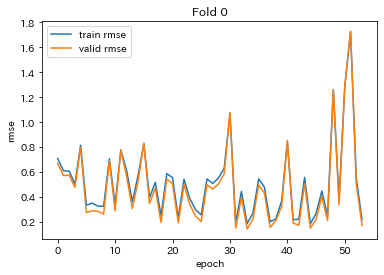


Early stopping occurred at epoch 33 with best_epoch = 13 and best_valid_rmse = 0.19503
Best weights from best epoch are automatically used!


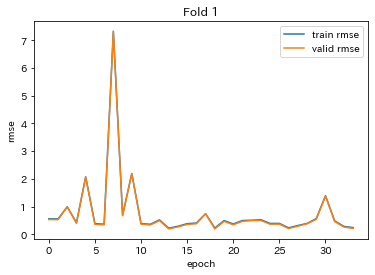


Early stopping occurred at epoch 59 with best_epoch = 39 and best_valid_rmse = 0.14697
Best weights from best epoch are automatically used!


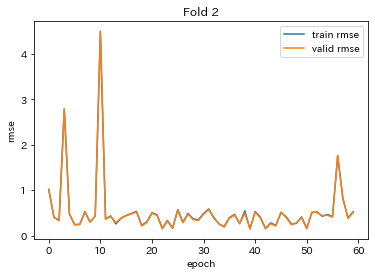


Early stopping occurred at epoch 24 with best_epoch = 4 and best_valid_rmse = 0.16131
Best weights from best epoch are automatically used!


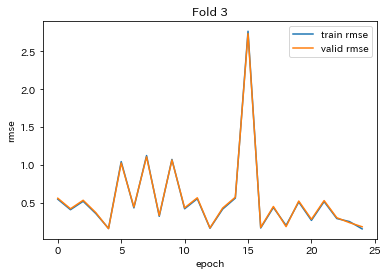


Early stopping occurred at epoch 28 with best_epoch = 8 and best_valid_rmse = 0.20789
Best weights from best epoch are automatically used!


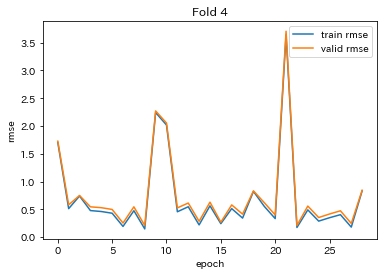

RMSE: [0.14451701333309377, 0.19503201903187828, 0.14696795274172914, 0.16130733376667836, 0.20789060325743414]
RMSE: 0.17114298442616274


In [9]:
model = TabNetRegressor(
                seed=SEED,
                verbose=0,
#                 device_name = "cuda", # GPU使用
)

# 学習・推論
gkf = GroupKFold(n_splits=5)

groups = X_train_tf[:, 0]

cv_result_tbnt = []

for i, (train_index, test_index) in enumerate(gkf.split(X_train_tf, y_train, groups)):
    X_train_gkf, X_test_gkf = X_train_tf[train_index], X_train_tf[test_index]
    y_train_gkf, y_test_gkf = y_train.iloc[train_index], y_train.iloc[test_index]

    model.fit(
                X_train=X_train_gkf,
                y_train=y_train_gkf.values.reshape(-1, 1),
                eval_set=[(X_train_gkf, y_train_gkf.values.reshape(-1, 1)), (X_test_gkf, y_test_gkf.values.reshape(-1, 1))],
                eval_name = ["train", "valid"],
                eval_metric = ["rmse"],
                max_epochs=200,
                patience=20, 
                batch_size=256, 
                virtual_batch_size=128,
                num_workers=0, 
                drop_last=False,
    )

    # 損失推移
    plt.title(f"Fold {i}")
    plt.plot(model.history['train_rmse'], label="train rmse")
    plt.plot(model.history['valid_rmse'], label="valid rmse")
    plt.xlabel("epoch")
    plt.ylabel("rmse")
    plt.legend()
    plt.show()

    # 推論
    y_pred = model.predict(X_test_gkf)

    # 評価
    rmse = mean_squared_error(y_test_gkf, y_pred, squared=False)
    cv_result_tbnt.append(rmse)

print("RMSE:", cv_result_tbnt)
print("RMSE:", np.mean(cv_result_tbnt))

In [10]:
print("LightGBM RMSE:", round(np.mean(cv_result_lgbm),3))
print("TabNet RMSE:", round(np.mean(cv_result_tbnt),3))

LightGBM RMSE: 0.192
TabNet RMSE: 0.171


### OneHot後のカラムを付けたDataFrameを作成する

In [11]:
print(len(X_train))

pd.DataFrame(X_train.isnull().sum()).T

13590


,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,User_Score,Total_Shipped,Year,Last_Update,url,status,Vgchartzscore,img_url
0,0,0,0,0,3911,0,0,3,13590,10599,13480,13590,29,10929,0,0,13270,0


In [12]:
### Nullのみで削除されるカラムを削除
print(len(number_columns))

for column in ["VGChartz_Score", "Total_Shipped"]:
    number_columns.remove(column)

print(len(number_columns))

8
6


In [13]:
# OneHotを考慮したの全カラム作成
all_columns = number_columns + \
                        many_kinds_category_columns + \
                        pipe["columns_transformers"].transformers_[2][1]["onehot"].get_feature_names(few_kinds_category_columns).tolist()

print(len(number_columns), len(many_kinds_category_columns), len(pipe["columns_transformers"].transformers_[2][1]["onehot"].get_feature_names(few_kinds_category_columns).tolist()))
print(len(all_columns))

6 9 6
21


In [14]:
X_train_tf_pd = pd.DataFrame(
                X_train_tf,
                columns=all_columns
            )

### Feature Importance

Text(0.5, 1.0, 'feature_importance')

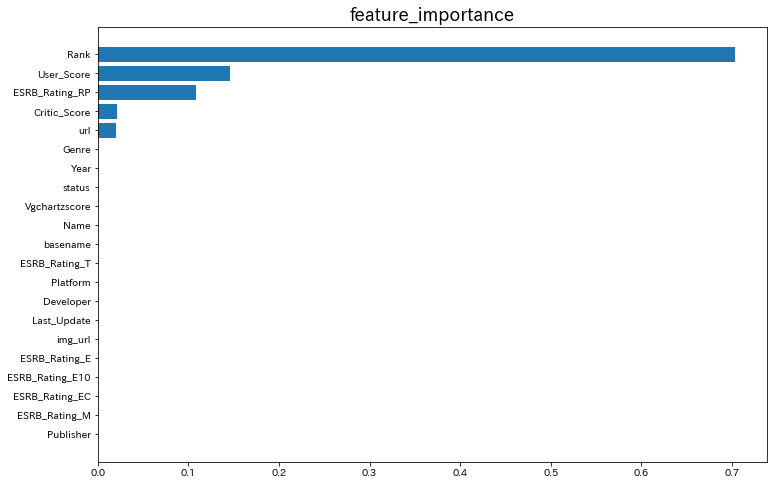

In [15]:
feat_imp = pd.DataFrame(model.feature_importances_, index=X_train_tf_pd.columns)
feature_importance = feat_imp.copy()

feature_importance["imp_mean"] = feature_importance.mean(axis=1)
feature_importance = feature_importance.sort_values("imp_mean")

plt.figure(figsize=(12, 8))
plt.barh(feature_importance.index.values, feature_importance["imp_mean"])
plt.title("feature_importance", fontsize=18)

### mask の可視化

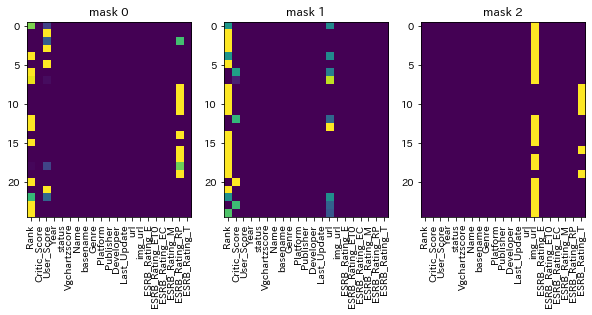

In [16]:
from matplotlib import ticker

explain_matrix, masks = model.explain(X_train_tf)

fig, axs = plt.subplots(1, 3, figsize=(10, 7))

for i in range(3):
    axs[i].imshow(masks[i][:25])
    axs[i].set_title(f"mask {i}")
    axs[i].set_xticklabels([0] + X_train_tf_pd.columns.tolist(), rotation=90)
    axs[i].xaxis.set_major_locator(ticker.MultipleLocator(1))